In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
hdb = pd.read_csv("../data/Resale flat prices based on registration date from Jan-2017 onwards.csv")
cea = pd.read_csv("../data/CEASalespersonsPropertyTransactionRecordsresidential.csv")

In [3]:
hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [4]:
cea.head()

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-


In [5]:
# clean hdb month
hdb["month_dt"] = pd.to_datetime(hdb["month"] + "-01")
hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,month_dt
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017-01-01
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017-01-01
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017-01-01
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017-01-01
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017-01-01


In [6]:
# filter out only HDB resale transactions
cea_hdb = cea[
    (cea["property_type"].astype(str).str.upper() == "HDB")
    & (cea["transaction_type"].astype(str).str.upper() == "RESALE")
].copy()

# clean and align cea month with hdb
cea_hdb["transaction_date_clean"] = cea_hdb["transaction_date"].astype(str).str.strip().str.title()
cea_hdb["month_dt"] = pd.to_datetime(
    cea_hdb["transaction_date_clean"], format="%b-%Y", errors="coerce"
)

cea_hdb.head()

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location,transaction_date_clean,month_dt
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-,Oct-2017,2017-10-01
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-,Mar-2018,2018-03-01
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-,Jan-2017,2017-01-01
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,May-2018,2018-05-01
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,Nov-2017,2017-11-01


In [7]:
# aggregate into monthly for both datasets and join
hdb_m = (
    hdb.groupby("month_dt")
    .agg(
        total_resales=("resale_price", "size"), # number of resales
        median_price=("resale_price", "median"), # median resale price
        mean_price=("resale_price", "mean"), # mean resale price
    )
    .reset_index()
    .sort_values("month_dt")
)

cea_m = (
    cea_hdb.groupby("month_dt")
    .agg(
        agent_engagements=("salesperson_reg_num", "size"), # number of agent resales
        active_agents=("salesperson_reg_num", "nunique"), # unique number of agents involved
    )
    .reset_index()
    .sort_values("month_dt")
)

m = (
    hdb_m.merge(cea_m, on="month_dt", how="left")
    .fillna({"agent_engagements": 0, "active_agents": 0})
)

In [8]:
# derive metrics from individual numbers
m["engagements_per_resale"] = m["agent_engagements"] / m["total_resales"] # average number of agents per resale
m["side_representation_rate"] = m["agent_engagements"] / (2 * m["total_resales"])  # proxy for number of agents per buy/sell side
m["side_representation_rate_capped"] = m["side_representation_rate"].clip(upper=1.0)
m["engagements_per_agent"] = m["agent_engagements"] / m["active_agents"].replace(0, np.nan) # average number of resale per active agents

# 3 month rolling mean smoothing
for col in ["total_resales", "agent_engagements", "active_agents", "side_representation_rate_capped", "engagements_per_agent"]:
    m[f"{col}_roll3"] = m[col].rolling(3, min_periods=1).mean()

In [9]:
# aggregate into yearly from monthly
m["year"] = m["month_dt"].dt.year

y = (
    m.groupby("year")
    .agg(
        total_resales=("total_resales", "sum"), # number of resales
        agent_engagements=("agent_engagements", "sum"), # number of agent resales 
        active_agents=("active_agents", "mean"), # mean number of agents involved
        median_price=("median_price", "median"), # median resale price
    )
    .reset_index()
)

In [10]:
# derive metrics from individual numbers
y["side_representation_rate"] = y["agent_engagements"] / (2 * y["total_resales"]) # proxy for number of agents per buy/sell side
y["side_representation_rate_capped"] = y["side_representation_rate"].clip(upper=1.0)
y["engagements_per_agent"] = y["agent_engagements"] / y["active_agents"].replace(0, np.nan) # average number of resale per active agents

In [11]:
# DIY estimate 
# assume roughly 2 agents per agent resale (buyer + seller)
# estimated agent resale = agent_engagements / 2
# estimated DIY = total - agent_engagements / 2
y["est_agent_assisted_txn"] = (y["agent_engagements"] / 2.0).clip(lower=0)
y["est_diy_txn"] = (y["total_resales"] - y["est_agent_assisted_txn"]).clip(lower=0)

# commission loss proxy 
# assume 1-2% of resale price
for rate in [0.01, 0.02]:
    y[f"est_commission_foregone_{int(rate*100)}pct_SGD"] = y["est_diy_txn"] * y["median_price"] * rate

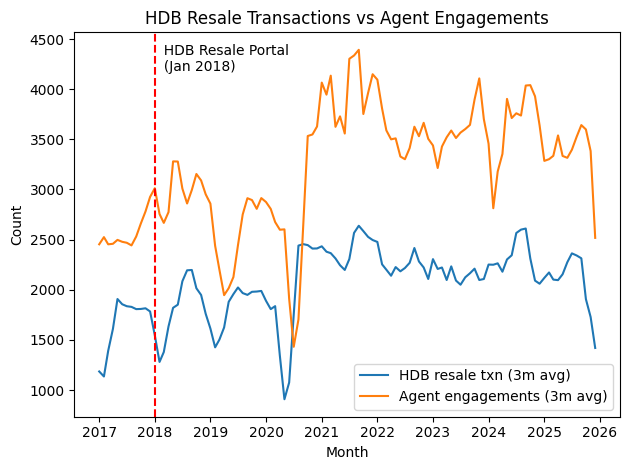

In [12]:
LAUNCH_DT = pd.Timestamp("2018-01-01")
LAUNCH_YEAR = 2018

plt.figure()
plt.plot(m["month_dt"], m["total_resales_roll3"], label="HDB resale txn (3m avg)")
plt.plot(m["month_dt"], m["agent_engagements_roll3"], label="Agent engagements (3m avg)")
plt.title("HDB Resale Transactions vs Agent Engagements")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()

ax = plt.gca()
ax.axvline(LAUNCH_DT, linestyle="--", c="red")
ax.text(LAUNCH_DT, 0.97, "  HDB Resale Portal\n  (Jan 2018)", transform=ax.get_xaxis_transform(), va="top")

plt.tight_layout()
plt.savefig("hdb_resale_vs_agent_engagements.png")
plt.show()

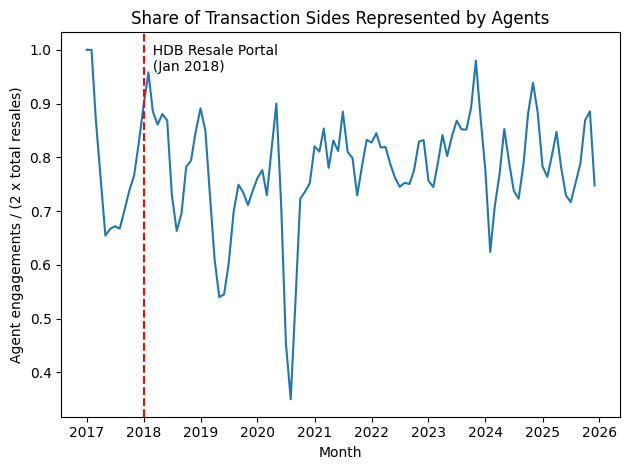

In [13]:
plt.figure()
plt.plot(m["month_dt"], m["side_representation_rate_capped_roll3"])
plt.title("Share of Transaction Sides Represented by Agents")
plt.xlabel("Month")
plt.ylabel("Agent engagements / (2 x total resales)")

ax = plt.gca()
ax.axvline(LAUNCH_DT, linestyle="--", c="red")
ax.text(LAUNCH_DT, 0.97, "  HDB Resale Portal\n  (Jan 2018)", transform=ax.get_xaxis_transform(), va="top")

plt.tight_layout()
plt.savefig("side_representation_rate.png")
plt.show()

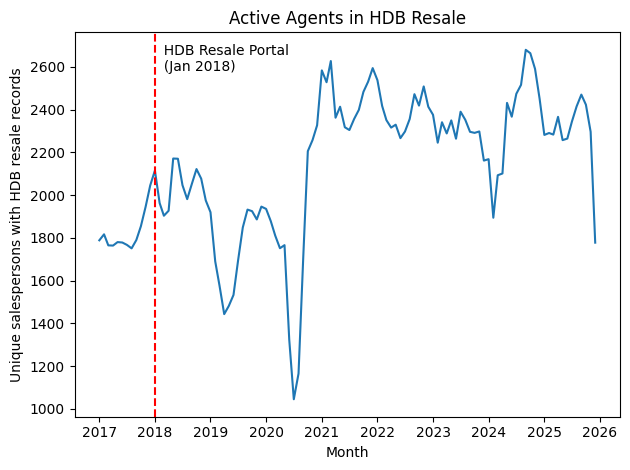

In [14]:
plt.figure()
plt.plot(m["month_dt"], m["active_agents_roll3"])
plt.title("Active Agents in HDB Resale")
plt.xlabel("Month")
plt.ylabel("Unique salespersons with HDB resale records")

ax = plt.gca()
ax.axvline(LAUNCH_DT, linestyle="--", c="red")
ax.text(LAUNCH_DT, 0.97, "  HDB Resale Portal\n  (Jan 2018)", transform=ax.get_xaxis_transform(), va="top")

plt.tight_layout()
plt.savefig("active_agents.png")
plt.show()

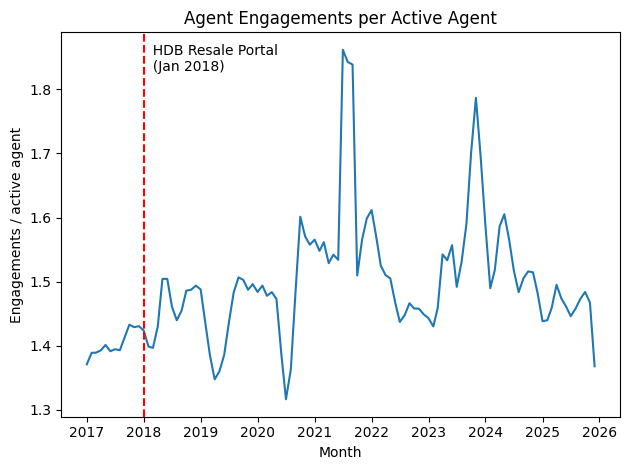

In [15]:
plt.figure()
plt.plot(m["month_dt"], m["engagements_per_agent_roll3"])
plt.title("Agent Engagements per Active Agent")
plt.xlabel("Month")
plt.ylabel("Engagements / active agent")

ax = plt.gca()
ax.axvline(LAUNCH_DT, linestyle="--", c="red")
ax.text(LAUNCH_DT, 0.97, "  HDB Resale Portal\n  (Jan 2018)", transform=ax.get_xaxis_transform(), va="top")

plt.tight_layout()
plt.savefig("engagements_per_agent.png")

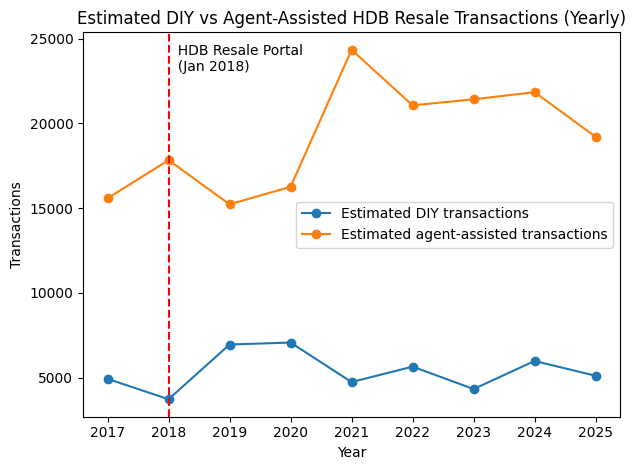

In [16]:
plt.figure()
plt.plot(y["year"], y["est_diy_txn"], marker="o", label="Estimated DIY transactions")
plt.plot(y["year"], y["est_agent_assisted_txn"], marker="o", label="Estimated agent-assisted transactions")
plt.title("Estimated DIY vs Agent-Assisted HDB Resale Transactions (Yearly)")
plt.xlabel("Year")
plt.ylabel("Transactions")

ax = plt.gca()
ax.axvline(LAUNCH_YEAR, linestyle="--", c="red")
ax.text(LAUNCH_YEAR, 0.97, "  HDB Resale Portal\n  (Jan 2018)", transform=ax.get_xaxis_transform(), va="top")

plt.legend()
plt.tight_layout()
plt.savefig("est_diy_vs_agent_resale.png")
plt.show()

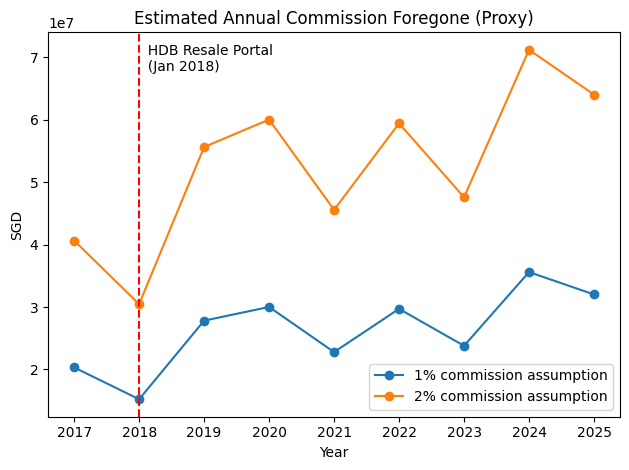

In [17]:
plt.figure()
plt.plot(y["year"], y["est_commission_foregone_1pct_SGD"], marker="o", label="1% commission assumption")
plt.plot(y["year"], y["est_commission_foregone_2pct_SGD"], marker="o", label="2% commission assumption")
plt.title("Estimated Annual Commission Foregone (Proxy)")
plt.xlabel("Year")
plt.ylabel("SGD")

ax = plt.gca()
ax.axvline(LAUNCH_YEAR, linestyle="--", c="red")
ax.text(LAUNCH_YEAR, 0.97, "  HDB Resale Portal\n  (Jan 2018)", transform=ax.get_xaxis_transform(), va="top")

plt.legend()
plt.tight_layout()
plt.savefig("commission_foregone_proxy.png")
plt.show()

In [18]:
table_yearly = y.copy()
table_yearly["active_agents"] = table_yearly["active_agents"].round(0).astype(int)
table_yearly["side_representation_rate"] = (table_yearly["side_representation_rate_capped"] * 100).round(1)
table_yearly["engagements_per_agent"] = table_yearly["engagements_per_agent"].round(2)
table_yearly["median_price"] = table_yearly["median_price"].round(0).astype(int)
for c in ["est_agent_assisted_txn", "est_diy_txn"]:
    table_yearly[c] = table_yearly[c].round(0).astype(int)
for c in ["est_commission_foregone_1pct_SGD", "est_commission_foregone_2pct_SGD"]:
    table_yearly[c] = table_yearly[c].round(0).astype(int)

table_yearly = table_yearly.rename(
    columns={
        "side_representation_rate": "side_representation_rate_pct",
        "median_price": "median_resale_price_SGD",
        "active_agents": "avg_monthly_active_agents",
        "agent_engagements": "agent_engagements_records",
    }
)[
    [
        "year",
        "total_resales",
        "agent_engagements_records",
        "side_representation_rate_pct",
        "avg_monthly_active_agents",
        "engagements_per_agent",
        "median_resale_price_SGD",
        "est_agent_assisted_txn",
        "est_diy_txn",
        "est_commission_foregone_1pct_SGD",
        "est_commission_foregone_2pct_SGD",
    ]
]

table_yearly

,year,total_resales,agent_engagements_records,side_representation_rate_pct,avg_monthly_active_agents,engagements_per_agent,median_resale_price_SGD,est_agent_assisted_txn,est_diy_txn,est_commission_foregone_1pct_SGD,est_commission_foregone_2pct_SGD
0,2017,20509,31162,76.0,1845,16.89,412500,15581,4928,20328000,40656000
1,2018,21561,35674,82.7,2026,17.61,409000,17837,3724,15231160,30462320
2,2019,22186,30461,68.6,1748,17.43,400000,15230,6956,27822000,55644000
3,2020,23333,32524,69.7,1793,18.14,424500,16262,7071,30016395,60032790
4,2021,29087,48699,83.7,2485,19.60,481000,24350,4738,22787375,45574750
5,2022,26720,42142,78.9,2376,17.73,526000,21071,5649,29713740,59427480
6,2023,25754,42856,83.2,2266,18.91,550000,21428,4326,23793000,47586000
7,2024,27832,43696,78.5,2398,18.22,595000,21848,5984,35604800,71209600
8,2025,24324,38428,79.0,2199,17.47,626500,19214,5110,32014150,64028300


In [19]:
table_yearly["period"] = np.where(table_yearly["year"] < 2018, "Pre-Portal (2017)", "Post-Portal (2018+)")
prepost = (
    table_yearly.groupby("period")
    .agg(
        years=("year", "count"),
        avg_resales=("total_resales", "mean"),
        avg_agent_engagements=("agent_engagements_records", "mean"),
        avg_side_rep_rate_pct=("side_representation_rate_pct", "mean"),
        avg_active_agents=("avg_monthly_active_agents", "mean"),
        avg_engagements_per_agent=("engagements_per_agent", "mean"),
        avg_est_DIY_txn=("est_diy_txn", "mean"),
        avg_comm_foregone_1pct=("est_commission_foregone_1pct_SGD", "mean"),
        avg_comm_foregone_2pct=("est_commission_foregone_2pct_SGD", "mean"),
    )
    .reset_index()
)
prepost

,period,years,avg_resales,avg_agent_engagements,avg_side_rep_rate_pct,avg_active_agents,avg_engagements_per_agent,avg_est_DIY_txn,avg_comm_foregone_1pct,avg_comm_foregone_2pct
0,Post-Portal (2018+),8,25099.625,39310.0,78.0375,2161.375,18.13875,5444.75,27122827.5,54245655.0
1,Pre-Portal (2017),1,20509.000,31162.0,76.0000,1845.000,16.89000,4928.00,20328000.0,40656000.0
